In [22]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, model_from_json
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [23]:
train_path = './SkinCancer/train'
valid_path = './SkinCancer/validation'
test_path = './SkinCancer/test'

IMG_SHAPE  = 224
batch_size = 32

In [24]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

VGG 16 Model V1

Preprocessing and Augmentation

In [6]:
vgg16_train_batches_v1 = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input, 
                                         rescale = 1./255,rotation_range = 90,
                                         width_shift_range=0.3,height_shift_range=0.3,
                                         shear_range = 0.3,zoom_range = 0.2,
                                         horizontal_flip = True,
                                         fill_mode = 'nearest') \
    .flow_from_directory(directory=train_path, target_size=(IMG_SHAPE,IMG_SHAPE), classes=['benign', 'malignant'], batch_size=batch_size, shuffle = True)
    
    
vgg16_valid_batches_v1 = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input, 
                                         rescale = 1./255,rotation_range = 90,
                                         width_shift_range=0.3,height_shift_range=0.3,
                                         shear_range = 0.3,zoom_range = 0.2,
                                         horizontal_flip = True,
                                         fill_mode = 'nearest') \
    .flow_from_directory(directory=valid_path, target_size=(IMG_SHAPE,IMG_SHAPE), classes=['benign', 'malignant'], batch_size=batch_size, shuffle = True)
    
    
vgg16_test_batches_v1 = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(IMG_SHAPE,IMG_SHAPE), classes=['benign', 'malignant'], batch_size=batch_size, shuffle=False)
imgs, labels = next(vgg16_train_batches_v1)

Found 1860 images belonging to 2 classes.
Found 520 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

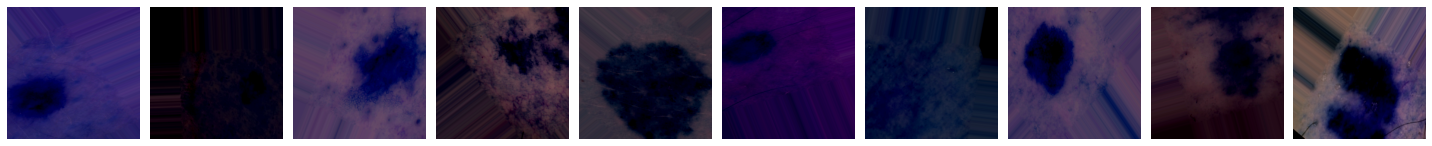

In [7]:
imgs, labels = next(vgg16_train_batches_v1)
plotImages(imgs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


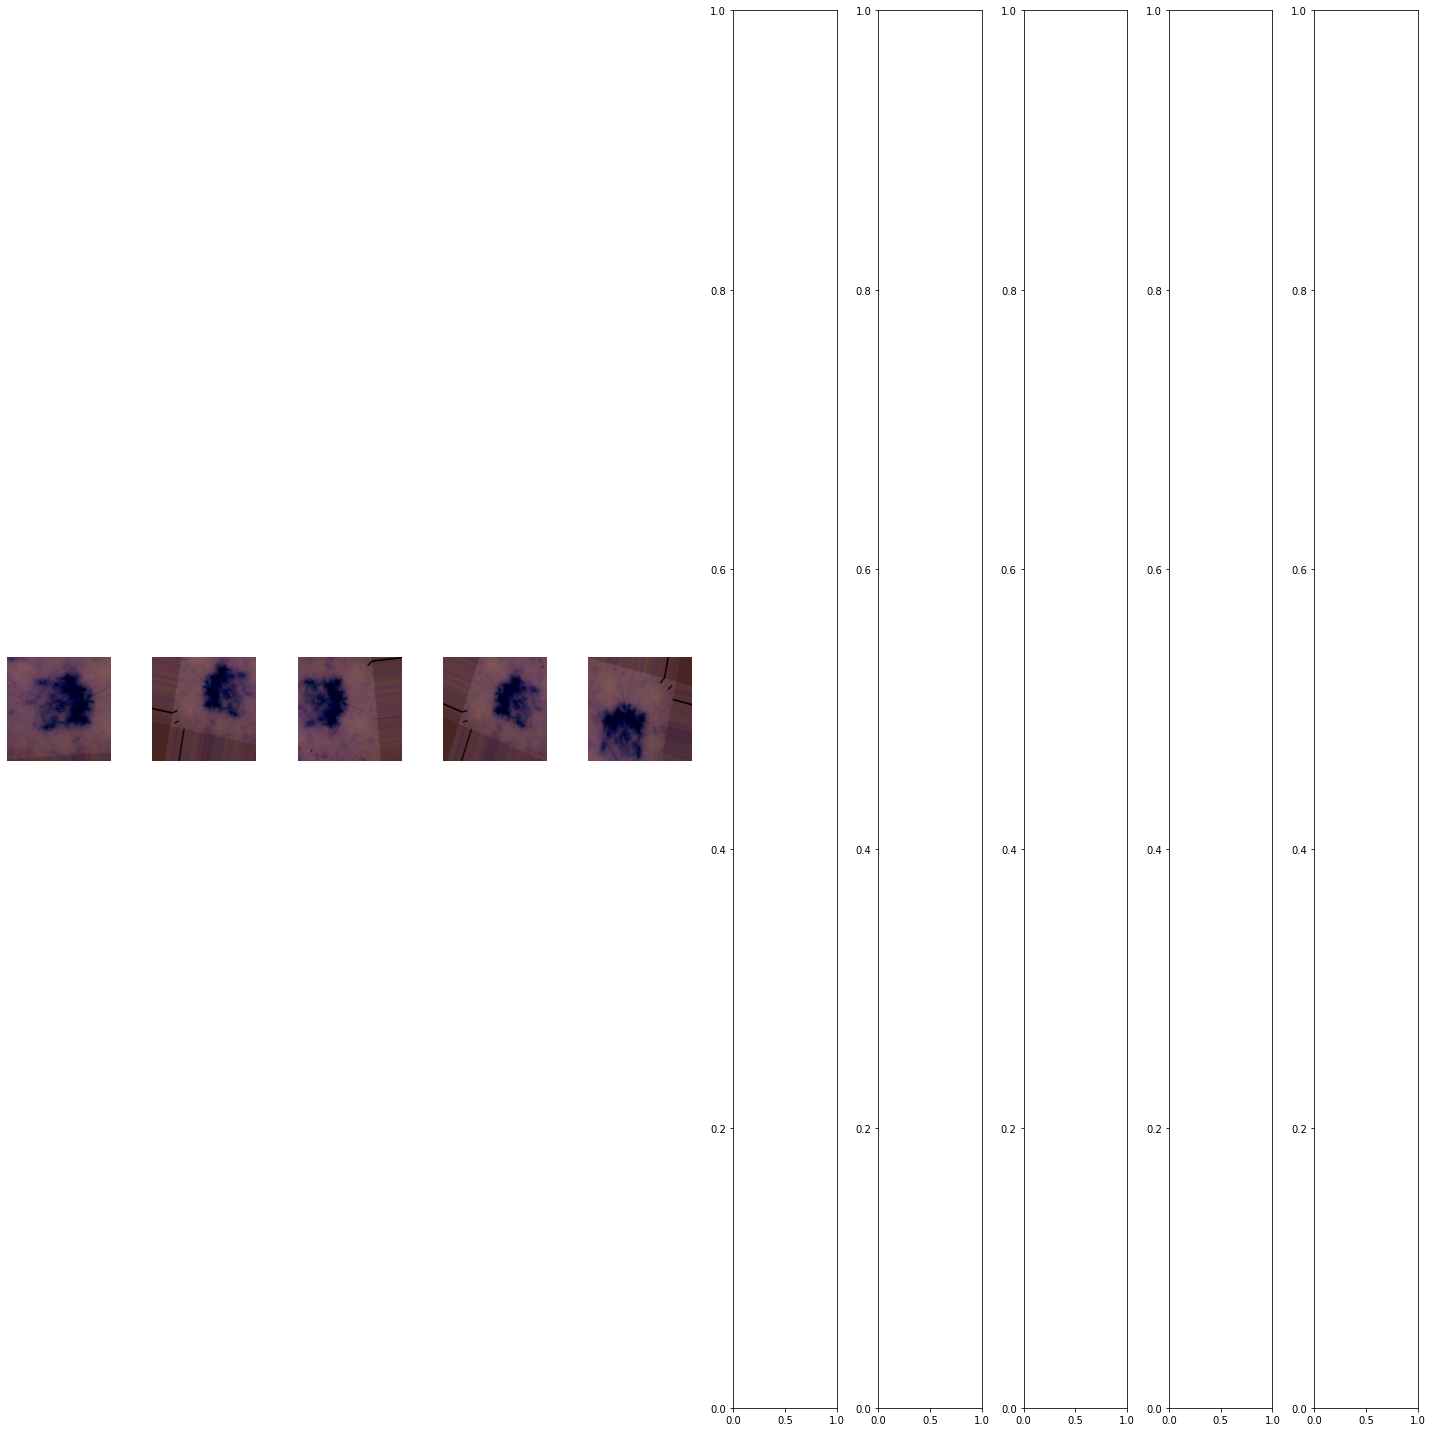

In [8]:
augmented_images = [vgg16_train_batches_v1[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [9]:
vgg16_model_v1 = Sequential([
        
        Conv2D(filters=16, kernel_size = (3,3), activation ='relu', padding='same', input_shape=(IMG_SHAPE,IMG_SHAPE, 3)),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        
        Conv2D(filters=32, kernel_size = (3,3), activation ='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        
        Conv2D(filters=64, kernel_size = (3,3), activation ='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        
        Conv2D(filters=128, kernel_size = (3,3), activation ='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        
        Flatten(),
        Dropout(0.5),
        
        Dense(units=512,kernel_regularizer = tf.keras.regularizers.l2(0.001), activation='relu'),
        Dense(units=2, activation='softmax')  
])

In [10]:
vgg16_model_v1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)       0

In [11]:
vgg16_model_v1.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
history_vgg16_model_v1 = vgg16_model_v1.fit(x=vgg16_train_batches_v1,
    steps_per_epoch=len(vgg16_train_batches_v1),
    validation_data=vgg16_valid_batches_v1,
    validation_steps=len(vgg16_valid_batches_v1),
    epochs=50,
    batch_size = batch_size,
    verbose=1
)

Epoch 1/50
59/59 [==============================] - 133s 2s/step - loss: 1.3577 - accuracy: 0.6984 - val_loss: 1.0179 - val_accuracy: 0.8231
Epoch 2/50
59/59 [==============================] - 126s 2s/step - loss: 0.9830 - accuracy: 0.7785 - val_loss: 0.8053 - val_accuracy: 0.8269
Epoch 3/50
59/59 [==============================] - 126s 2s/step - loss: 0.8170 - accuracy: 0.7892 - val_loss: 0.6874 - val_accuracy: 0.8288
Epoch 4/50
59/59 [==============================] - 125s 2s/step - loss: 0.7227 - accuracy: 0.7941 - val_loss: 0.7159 - val_accuracy: 0.7962
Epoch 5/50
59/59 [==============================] - 126s 2s/step - loss: 0.6692 - accuracy: 0.8016 - val_loss: 0.5625 - val_accuracy: 0.8346
Epoch 6/50
59/59 [==============================] - 124s 2s/step - loss: 0.6331 - accuracy: 0.7968 - val_loss: 0.5634 - val_accuracy: 0.8423
Epoch 7/50
59/59 [==============================] - 129s 2s/step - loss: 0.5949 - accuracy: 0.8027 - val_loss: 0.5172 - val_accuracy: 0.8288
Epoch 8/50
59

21/21 [==============================] - 11s 502ms/step
Confusion matrix, without normalization
[[304  56]
 [ 68 232]]


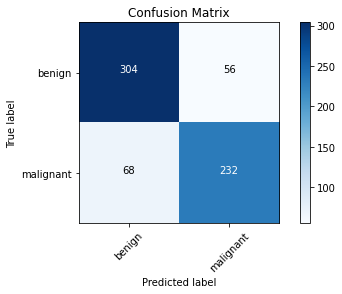

In [15]:
vgg16_predictions_v1 = vgg16_model_v1.predict(x=vgg16_test_batches_v1, steps=len(vgg16_test_batches_v1), verbose=1)
np.round(vgg16_predictions_v1)
vgg16_cm_v1 = confusion_matrix(y_true=vgg16_test_batches_v1.classes, y_pred=np.argmax(vgg16_predictions_v1, axis=-1))
cm_plot_labels = ['benign','malignant']
plot_confusion_matrix(cm=vgg16_cm_v1, classes=cm_plot_labels, title='Confusion Matrix')

In [16]:
vgg16_model_json = vgg16_model_v1.to_json()
with open("./SkinCancer_v3_Models/vgg16_model_v1/vgg16_model_v1.json", "w") as json_file:
    json_file.write(vgg16_model_json)
vgg16_model_v1.save("./SkinCancer_v3_Models/vgg16_model_v1/vgg16_model_v1.h5")
print("Saved model to disk")
vgg16_model_v1.save_weights("./SkinCancer_v3_Models/vgg16_model_v1/vgg16_model_v1_Weights.h5")

Saved model to disk


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


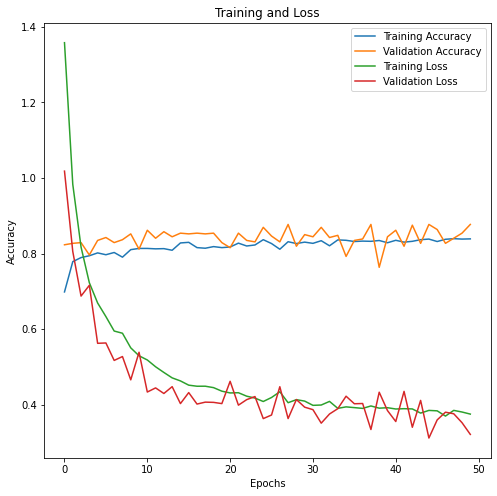

In [19]:
history_dict = history_vgg16_model_v1.history
print(history_dict.keys())

acc = history_vgg16_model_v1.history['accuracy']
val_acc = history_vgg16_model_v1.history['val_accuracy']

loss = history_vgg16_model_v1.history['loss']
val_loss = history_vgg16_model_v1.history['val_loss']

epochs_range = range(50)
plt.figure(figsize=(8, 8))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='best')
plt.title('Training and Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [21]:
vgg16_results_v1 = vgg16_model_v1.evaluate(x=vgg16_test_batches_v1, steps=len(vgg16_test_batches_v1), verbose=1)
print("test_loss, test accuracy",vgg16_results_v1)

21/21 [==============================] - 9s 430ms/step - loss: 57.9663 - accuracy: 0.8121
test_loss, test accuracy [57.96625900268555, 0.8121212124824524]


In [22]:
pred_class = np.argmax(vgg16_predictions_v1, axis=1)

true_classes = vgg16_test_batches_v1.classes
class_labels = list(vgg16_test_batches_v1.class_indices.keys())  
report = metrics.classification_report(pred_class,true_classes,target_names=class_labels)
print(report)

              precision    recall  f1-score   support

      benign       0.84      0.82      0.83       372
   malignant       0.77      0.81      0.79       288

    accuracy                           0.81       660
   macro avg       0.81      0.81      0.81       660
weighted avg       0.81      0.81      0.81       660



21/21 [==============================] - 9s 425ms/step


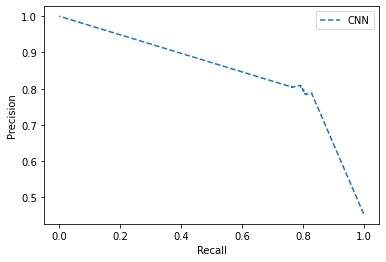

In [23]:
lr_probs = vgg16_model_v1.predict(x=vgg16_test_batches_v1, steps=len(vgg16_test_batches_v1), verbose=1)
lr_probs = lr_probs[:, 1]
lr_precision, lr_recall, _ = precision_recall_curve(true_classes, lr_probs)
no_skill = len(true_classes[true_classes==1]) / len(true_classes)
plt.plot(lr_recall, lr_precision, linestyle='--',label='CNN')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

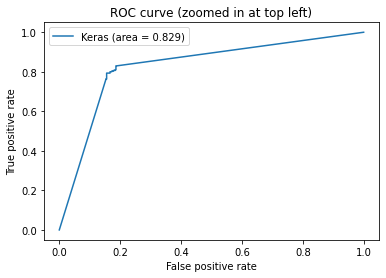

In [24]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(true_classes, lr_probs)
auc_keras = auc(fpr_keras, tpr_keras)
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

VGG 16 Model V2

Only preprocessing

In [6]:
vgg16_train_batches_v2 = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(IMG_SHAPE,IMG_SHAPE), classes=['benign', 'malignant'], batch_size=batch_size, shuffle = True)
    
    
vgg16_valid_batches_v2 = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(IMG_SHAPE,IMG_SHAPE), classes=['benign', 'malignant'], batch_size=batch_size, shuffle = True)
    
    
vgg16_test_batches_v2 = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(IMG_SHAPE,IMG_SHAPE), classes=['benign', 'malignant'], batch_size=batch_size, shuffle=False)
imgs, labels = next(vgg16_train_batches_v2)

Found 1860 images belonging to 2 classes.
Found 520 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

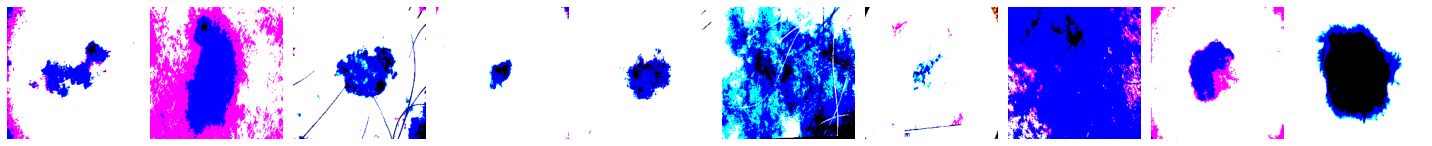

In [7]:
imgs, labels = next(vgg16_train_batches_v2)
plotImages(imgs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


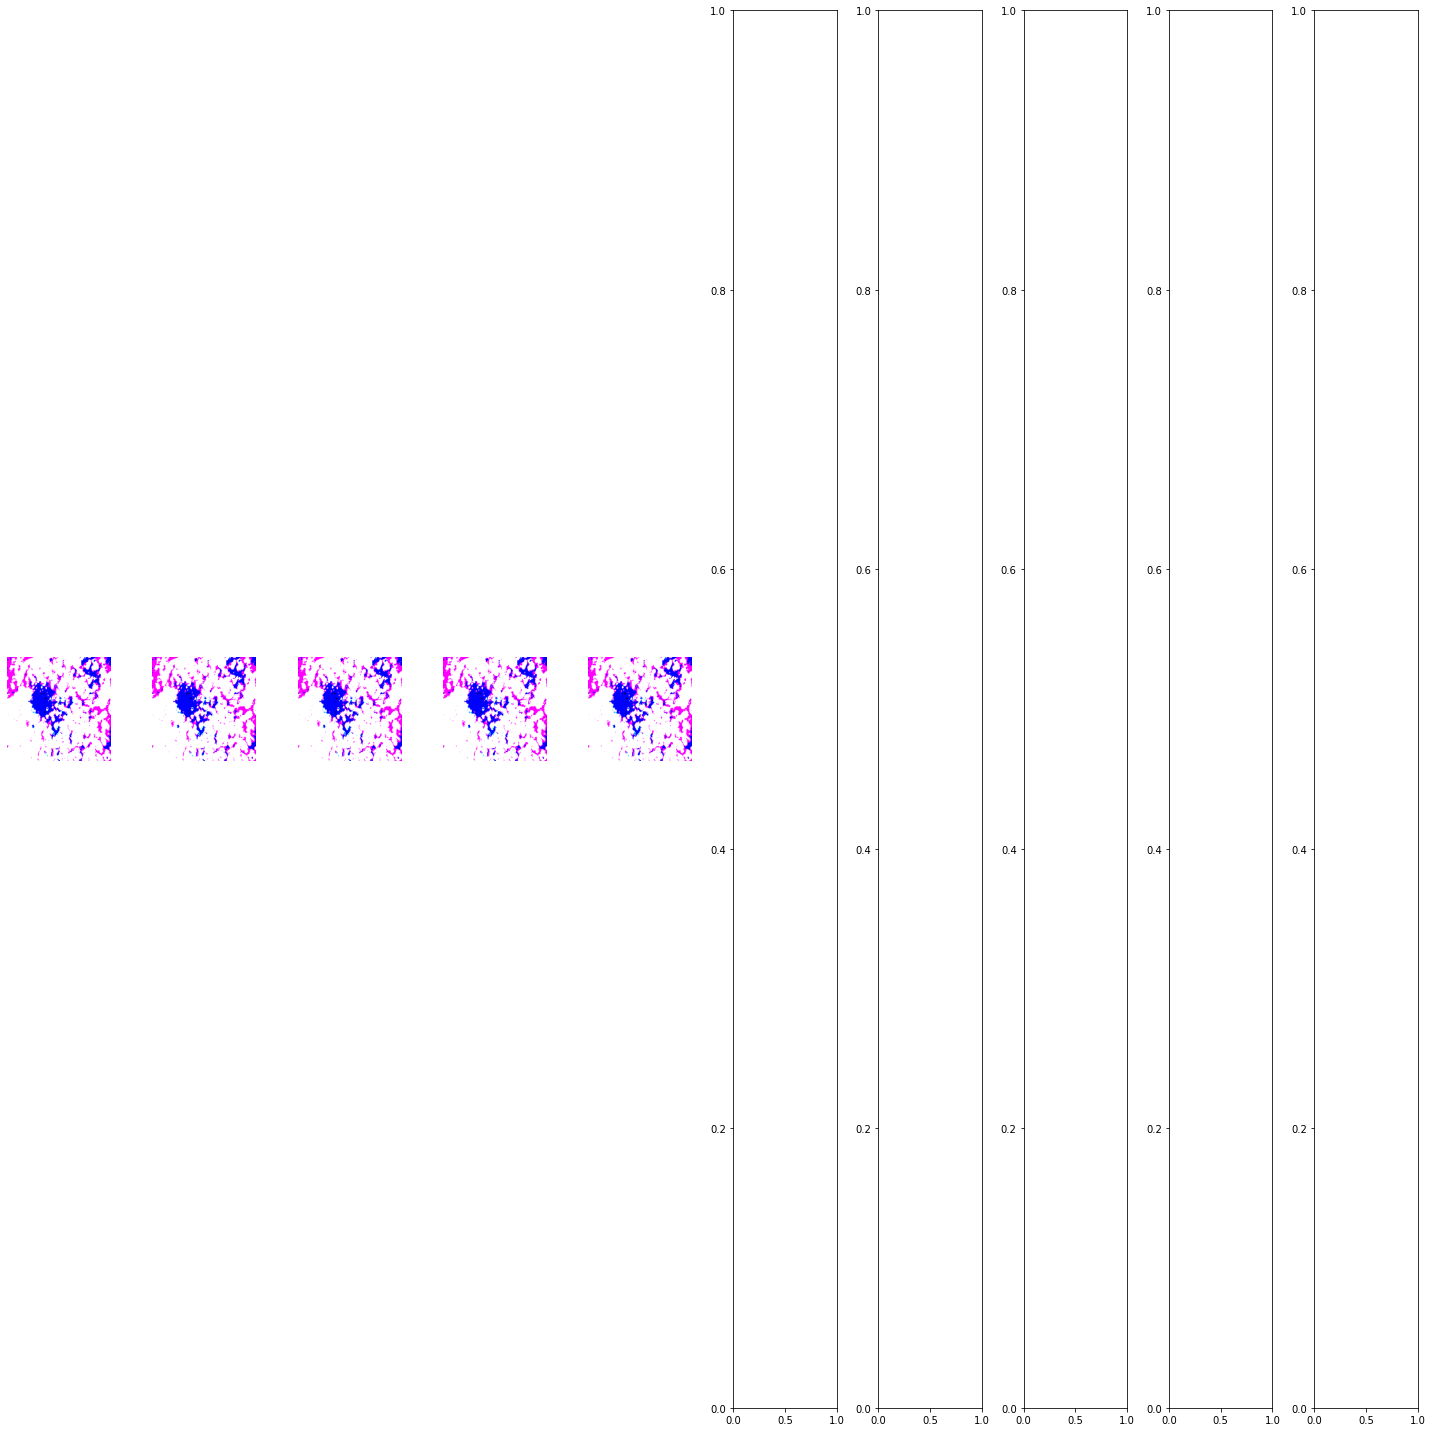

In [8]:
augmented_images = [vgg16_train_batches_v2[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [10]:
vgg16_model_v2 = Sequential([
        
        Conv2D(filters=16, kernel_size = (3,3), activation ='relu', padding='same', input_shape=(IMG_SHAPE,IMG_SHAPE, 3)),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        
        Conv2D(filters=32, kernel_size = (3,3), activation ='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        
        Conv2D(filters=64, kernel_size = (3,3), activation ='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        
        Conv2D(filters=128, kernel_size = (3,3), activation ='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        
        Flatten(),
        Dropout(0.5),
        
        Dense(units=512,kernel_regularizer = tf.keras.regularizers.l2(0.001), activation='relu'),
        Dense(units=2, activation='softmax')  
])

In [11]:
vgg16_model_v2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)       0

In [12]:
vgg16_model_v2.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
history_vgg16_model_v2 = vgg16_model_v2.fit(x=vgg16_train_batches_v2,
    steps_per_epoch=len(vgg16_train_batches_v2),
    validation_data=vgg16_valid_batches_v2,
    validation_steps=len(vgg16_valid_batches_v2),
    epochs=50,
    batch_size = batch_size,
    verbose=1
)

Epoch 1/50
59/59 [==============================] - 99s 2s/step - loss: 5.6643 - accuracy: 0.6419 - val_loss: 1.3994 - val_accuracy: 0.7577
Epoch 2/50
59/59 [==============================] - 94s 2s/step - loss: 1.3182 - accuracy: 0.7355 - val_loss: 1.1496 - val_accuracy: 0.8462
Epoch 3/50
59/59 [==============================] - 96s 2s/step - loss: 1.1958 - accuracy: 0.7833 - val_loss: 1.1605 - val_accuracy: 0.8231
Epoch 4/50
59/59 [==============================] - 95s 2s/step - loss: 1.1066 - accuracy: 0.8081 - val_loss: 1.0605 - val_accuracy: 0.8558
Epoch 5/50
59/59 [==============================] - 93s 2s/step - loss: 1.0787 - accuracy: 0.8134 - val_loss: 1.0870 - val_accuracy: 0.8115
Epoch 6/50
59/59 [==============================] - 94s 2s/step - loss: 1.0291 - accuracy: 0.8376 - val_loss: 1.0663 - val_accuracy: 0.8115
Epoch 7/50
59/59 [==============================] - 94s 2s/step - loss: 0.9896 - accuracy: 0.8511 - val_loss: 1.0884 - val_accuracy: 0.7769
Epoch 8/50
59/59 [==

21/21 [==============================] - 12s 569ms/step
Confusion matrix, without normalization
[[317  43]
 [ 52 248]]


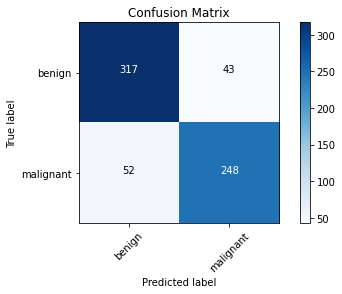

In [14]:
vgg16_predictions_v2 = vgg16_model_v2.predict(x=vgg16_test_batches_v2, steps=len(vgg16_test_batches_v2), verbose=1)
np.round(vgg16_predictions_v2)
vgg16_cm_v2 = confusion_matrix(y_true=vgg16_test_batches_v2.classes, y_pred=np.argmax(vgg16_predictions_v2, axis=-1))
cm_plot_labels = ['benign','malignant']
plot_confusion_matrix(cm=vgg16_cm_v2, classes=cm_plot_labels, title='Confusion Matrix')

In [15]:
vgg16_model_json = vgg16_model_v2.to_json()
with open("./SkinCancer_v3_Models/vgg16_model_v2/vgg16_model_v2.json", "w") as json_file:
    json_file.write(vgg16_model_json)
vgg16_model_v2.save("./SkinCancer_v3_Models/vgg16_model_v2/vgg16_model_v2.h5")
print("Saved model to disk")
vgg16_model_v2.save_weights("./SkinCancer_v3_Models/vgg16_model_v2/vgg16_model_v2_Weights.h5")

Saved model to disk


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


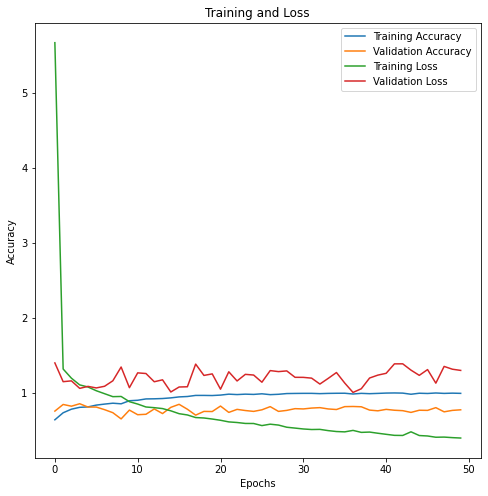

In [16]:
history_dict = history_vgg16_model_v2.history
print(history_dict.keys())

acc = history_vgg16_model_v2.history['accuracy']
val_acc = history_vgg16_model_v2.history['val_accuracy']

loss = history_vgg16_model_v2.history['loss']
val_loss = history_vgg16_model_v2.history['val_loss']

epochs_range = range(50)
plt.figure(figsize=(8, 8))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='best')
plt.title('Training and Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [17]:
vgg16_results_v2 = vgg16_model_v2.evaluate(x=vgg16_test_batches_v2, steps=len(vgg16_test_batches_v2), verbose=1)
print("test_loss, test accuracy",vgg16_results_v2)

21/21 [==============================] - 9s 435ms/step - loss: 1.0296 - accuracy: 0.8561
test_loss, test accuracy [1.0296258926391602, 0.8560606241226196]


In [18]:
pred_class = np.argmax(vgg16_predictions_v2, axis=1)

true_classes = vgg16_test_batches_v2.classes
class_labels = list(vgg16_test_batches_v2.class_indices.keys())  
report = metrics.classification_report(pred_class,true_classes,target_names=class_labels)
print(report)

              precision    recall  f1-score   support

      benign       0.88      0.86      0.87       369
   malignant       0.83      0.85      0.84       291

    accuracy                           0.86       660
   macro avg       0.85      0.86      0.85       660
weighted avg       0.86      0.86      0.86       660



21/21 [==============================] - 10s 441ms/step


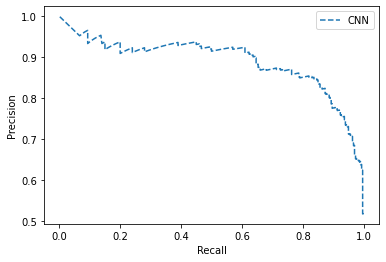

In [19]:
lr_probs = vgg16_model_v2.predict(x=vgg16_test_batches_v2, steps=len(vgg16_test_batches_v2), verbose=1)
lr_probs = lr_probs[:, 1]
lr_precision, lr_recall, _ = precision_recall_curve(true_classes, lr_probs)
no_skill = len(true_classes[true_classes==1]) / len(true_classes)
plt.plot(lr_recall, lr_precision, linestyle='--',label='CNN')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

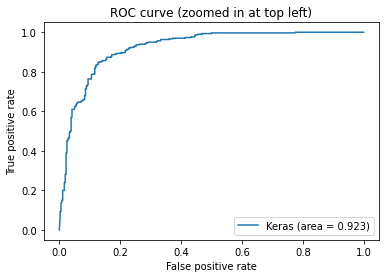

In [20]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(true_classes, lr_probs)
auc_keras = auc(fpr_keras, tpr_keras)
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

Resnet V2 Model V1

Preprocessing and Augmentation

In [29]:
resnet_v2_train_batches_v1 = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input, 
                                         rescale = 1./255,rotation_range = 90,
                                         width_shift_range=0.3,height_shift_range=0.3,
                                         shear_range = 0.3,zoom_range = 0.2,
                                         horizontal_flip = True,
                                         fill_mode = 'nearest') \
    .flow_from_directory(directory=train_path, target_size=(IMG_SHAPE,IMG_SHAPE), classes=['benign', 'malignant'], batch_size=batch_size, shuffle = True)
    
    
resnet_v2_valid_batches_v1 = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input, 
                                         rescale = 1./255,rotation_range = 90,
                                         width_shift_range=0.3,height_shift_range=0.3,
                                         shear_range = 0.3,zoom_range = 0.2,
                                         horizontal_flip = True,
                                         fill_mode = 'nearest') \
    .flow_from_directory(directory=valid_path, target_size=(IMG_SHAPE,IMG_SHAPE), classes=['benign', 'malignant'], batch_size=batch_size, shuffle = True)
    
    
resnet_v2_test_batches_v1 = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(IMG_SHAPE,IMG_SHAPE), classes=['benign', 'malignant'], batch_size=batch_size, shuffle=False)
imgs, labels = next(resnet_v2_train_batches_v1)

Found 1860 images belonging to 2 classes.
Found 520 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

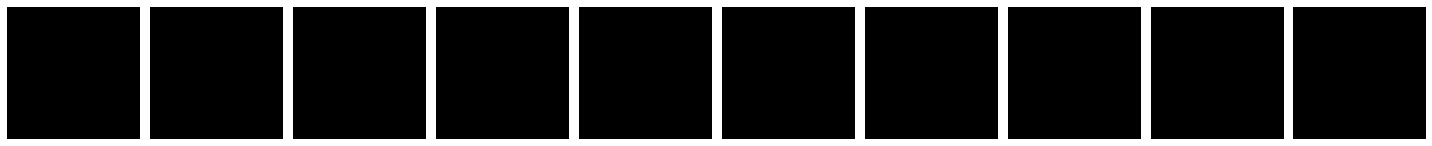

In [30]:
imgs, labels = next(resnet_v2_train_batches_v1)
plotImages(imgs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


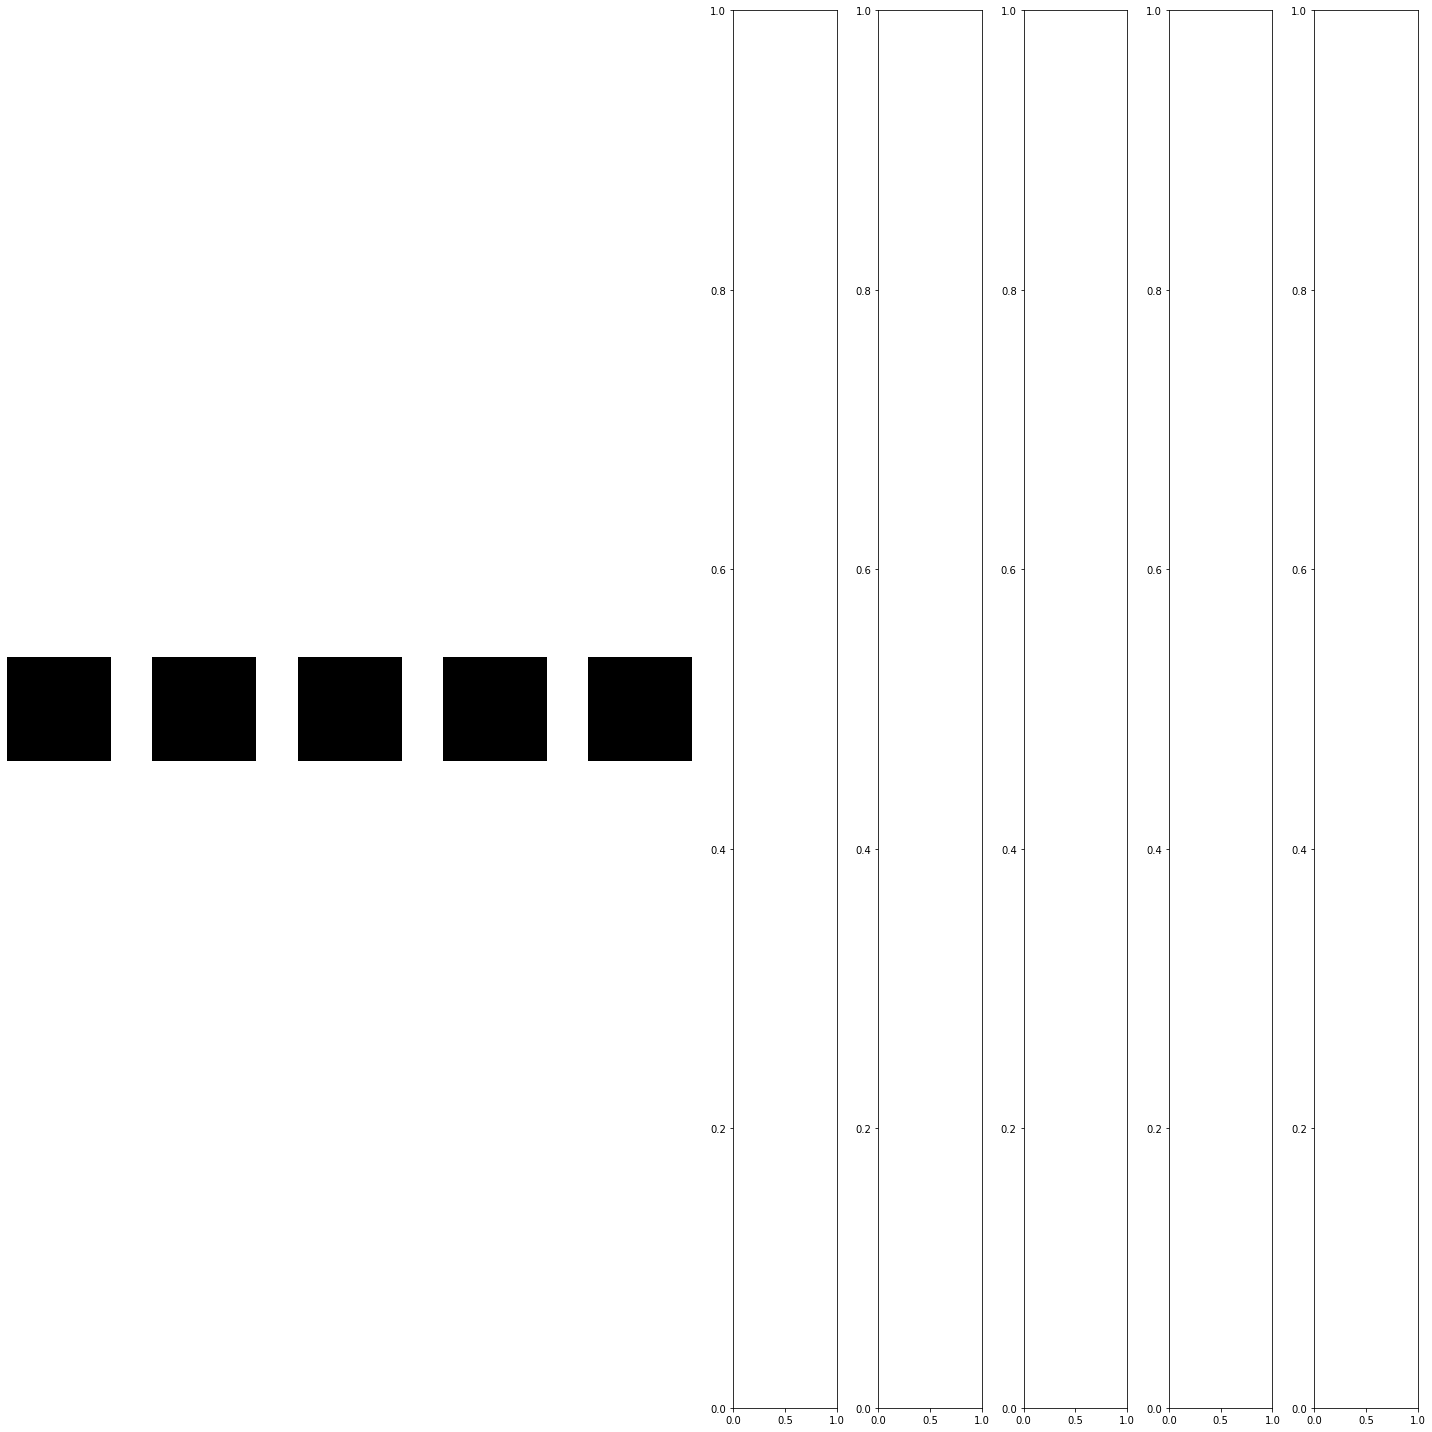

In [31]:
augmented_images = [resnet_v2_train_batches_v1[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [32]:
resnet_v2_model_v1 = Sequential([
        
        Conv2D(filters=16, kernel_size = (3,3), activation ='relu', padding='same', input_shape=(IMG_SHAPE,IMG_SHAPE, 3)),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        
        Conv2D(filters=32, kernel_size = (3,3), activation ='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        
        Conv2D(filters=64, kernel_size = (3,3), activation ='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        
        Conv2D(filters=128, kernel_size = (3,3), activation ='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        
        Flatten(),
        Dropout(0.5),
        
        Dense(units=512,kernel_regularizer = tf.keras.regularizers.l2(0.001), activation='relu'),
        Dense(units=2, activation='softmax')  
])

In [34]:
resnet_v2_model_v1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 28, 28, 64)      

In [35]:
resnet_v2_model_v1.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
history_resnet_v2_model_v1 = resnet_v2_model_v1.fit(x=resnet_v2_train_batches_v1,
    steps_per_epoch=len(resnet_v2_train_batches_v1),
    validation_data=resnet_v2_valid_batches_v1,
    validation_steps=len(resnet_v2_valid_batches_v1),
    epochs=50,
    batch_size = batch_size,
    verbose=1
)

Epoch 1/50
59/59 [==============================] - 124s 2s/step - loss: 1.2979 - accuracy: 0.5339 - val_loss: 0.9826 - val_accuracy: 0.6077
Epoch 2/50
59/59 [==============================] - 102s 2s/step - loss: 0.8340 - accuracy: 0.6253 - val_loss: 0.6791 - val_accuracy: 0.7538
Epoch 3/50
59/59 [==============================] - 98s 2s/step - loss: 0.6400 - accuracy: 0.7011 - val_loss: 0.6204 - val_accuracy: 0.7192
Epoch 4/50
59/59 [==============================] - 104s 2s/step - loss: 0.5788 - accuracy: 0.7258 - val_loss: 0.5274 - val_accuracy: 0.7538
Epoch 5/50
59/59 [==============================] - 103s 2s/step - loss: 0.5536 - accuracy: 0.7489 - val_loss: 0.5138 - val_accuracy: 0.7635
Epoch 6/50
59/59 [==============================] - 101s 2s/step - loss: 0.5472 - accuracy: 0.7414 - val_loss: 0.4993 - val_accuracy: 0.7673
Epoch 7/50
59/59 [==============================] - 99s 2s/step - loss: 0.5434 - accuracy: 0.7495 - val_loss: 0.5174 - val_accuracy: 0.7942
Epoch 8/50
59/5

21/21 [==============================] - 7s 346ms/step
Confusion matrix, without normalization
[[313  47]
 [161 139]]


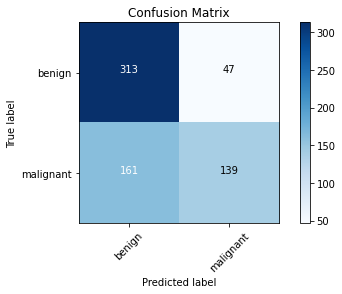

In [37]:
resnet_v2_predictions_v1 = resnet_v2_model_v1.predict(x=resnet_v2_test_batches_v1, steps=len(resnet_v2_test_batches_v1), verbose=1)
np.round(resnet_v2_predictions_v1)
resnet_v2_cm_v1 = confusion_matrix(y_true=resnet_v2_test_batches_v1.classes, y_pred=np.argmax(resnet_v2_predictions_v1, axis=-1))
cm_plot_labels = ['benign','malignant']
plot_confusion_matrix(cm=resnet_v2_cm_v1, classes=cm_plot_labels, title='Confusion Matrix')

In [38]:
resnet_v2_model_json = resnet_v2_model_v1.to_json()
with open("./SkinCancer_v3_Models/resnetV2_model_v1/resnet_v2_model_v1.json", "w") as json_file:
    json_file.write(resnet_v2_model_json)
resnet_v2_model_v1.save("./SkinCancer_v3_Models/resnetV2_model_v1/resnet_v2_model_v1.h5")
print("Saved model to disk")
resnet_v2_model_v1.save_weights("./SkinCancer_v3_Models/resnetV2_model_v1/resnet_v2_model_v1_Weights.h5")

Saved model to disk


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


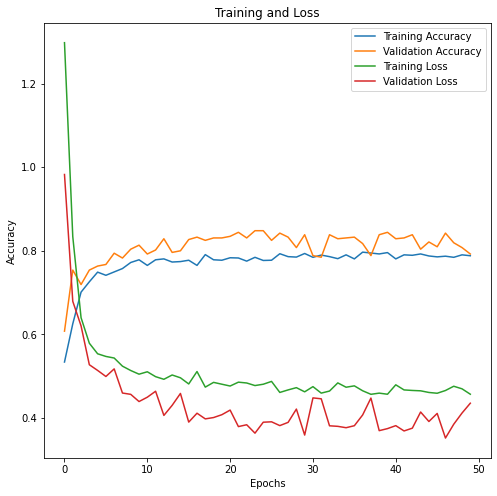

In [39]:
history_dict = history_resnet_v2_model_v1.history
print(history_dict.keys())

acc = history_resnet_v2_model_v1.history['accuracy']
val_acc = history_resnet_v2_model_v1.history['val_accuracy']

loss = history_resnet_v2_model_v1.history['loss']
val_loss = history_resnet_v2_model_v1.history['val_loss']

epochs_range = range(50)
plt.figure(figsize=(8, 8))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='best')
plt.title('Training and Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [40]:
resnet_v2_results_v1 = resnet_v2_model_v1.evaluate(x=resnet_v2_test_batches_v1, steps=len(resnet_v2_test_batches_v1), verbose=1)
print("test_loss, test accuracy",resnet_v2_results_v1)

21/21 [==============================] - 8s 357ms/step - loss: 40.2405 - accuracy: 0.6848
test_loss, test accuracy [40.24053192138672, 0.6848484873771667]


In [41]:
pred_class = np.argmax(resnet_v2_predictions_v1, axis=1)

true_classes = resnet_v2_test_batches_v1.classes
class_labels = list(resnet_v2_test_batches_v1.class_indices.keys())  
report = metrics.classification_report(pred_class,true_classes,target_names=class_labels)
print(report)

              precision    recall  f1-score   support

      benign       0.87      0.66      0.75       474
   malignant       0.46      0.75      0.57       186

    accuracy                           0.68       660
   macro avg       0.67      0.70      0.66       660
weighted avg       0.75      0.68      0.70       660



21/21 [==============================] - 9s 418ms/step


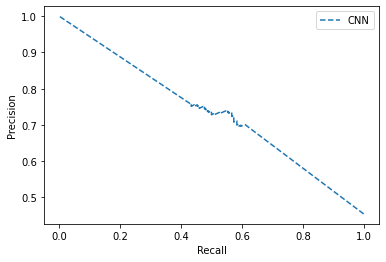

In [42]:
lr_probs = resnet_v2_model_v1.predict(x=resnet_v2_test_batches_v1, steps=len(resnet_v2_test_batches_v1), verbose=1)
lr_probs = lr_probs[:, 1]
lr_precision, lr_recall, _ = precision_recall_curve(true_classes, lr_probs)
no_skill = len(true_classes[true_classes==1]) / len(true_classes)
plt.plot(lr_recall, lr_precision, linestyle='--',label='CNN')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

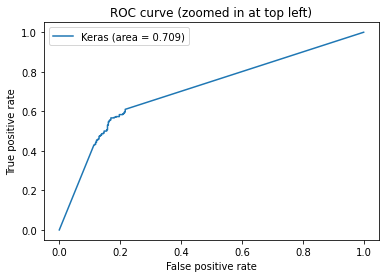

In [43]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(true_classes, lr_probs)
auc_keras = auc(fpr_keras, tpr_keras)
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

Resnet V2 Model V2

Only Preprocessing

In [44]:
resnet_v2_train_batches_v2 = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(IMG_SHAPE,IMG_SHAPE), classes=['benign', 'malignant'], batch_size=batch_size, shuffle = True)
    
    
resnet_v2_valid_batches_v2 = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(IMG_SHAPE,IMG_SHAPE), classes=['benign', 'malignant'], batch_size=batch_size, shuffle = True)
    
    
resnet_v2_test_batches_v2 = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(IMG_SHAPE,IMG_SHAPE), classes=['benign', 'malignant'], batch_size=batch_size, shuffle=False)
imgs, labels = next(resnet_v2_train_batches_v1)

Found 1860 images belonging to 2 classes.
Found 520 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

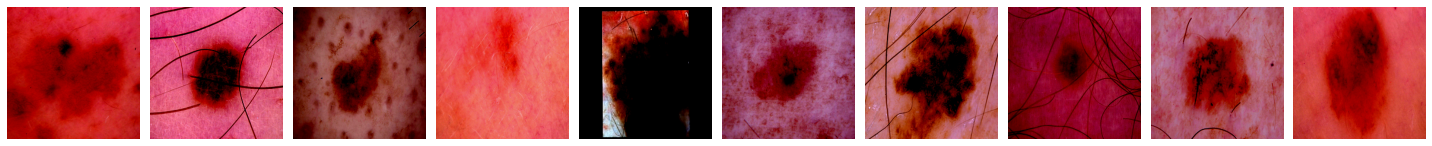

In [45]:
imgs, labels = next(resnet_v2_train_batches_v2)
plotImages(imgs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


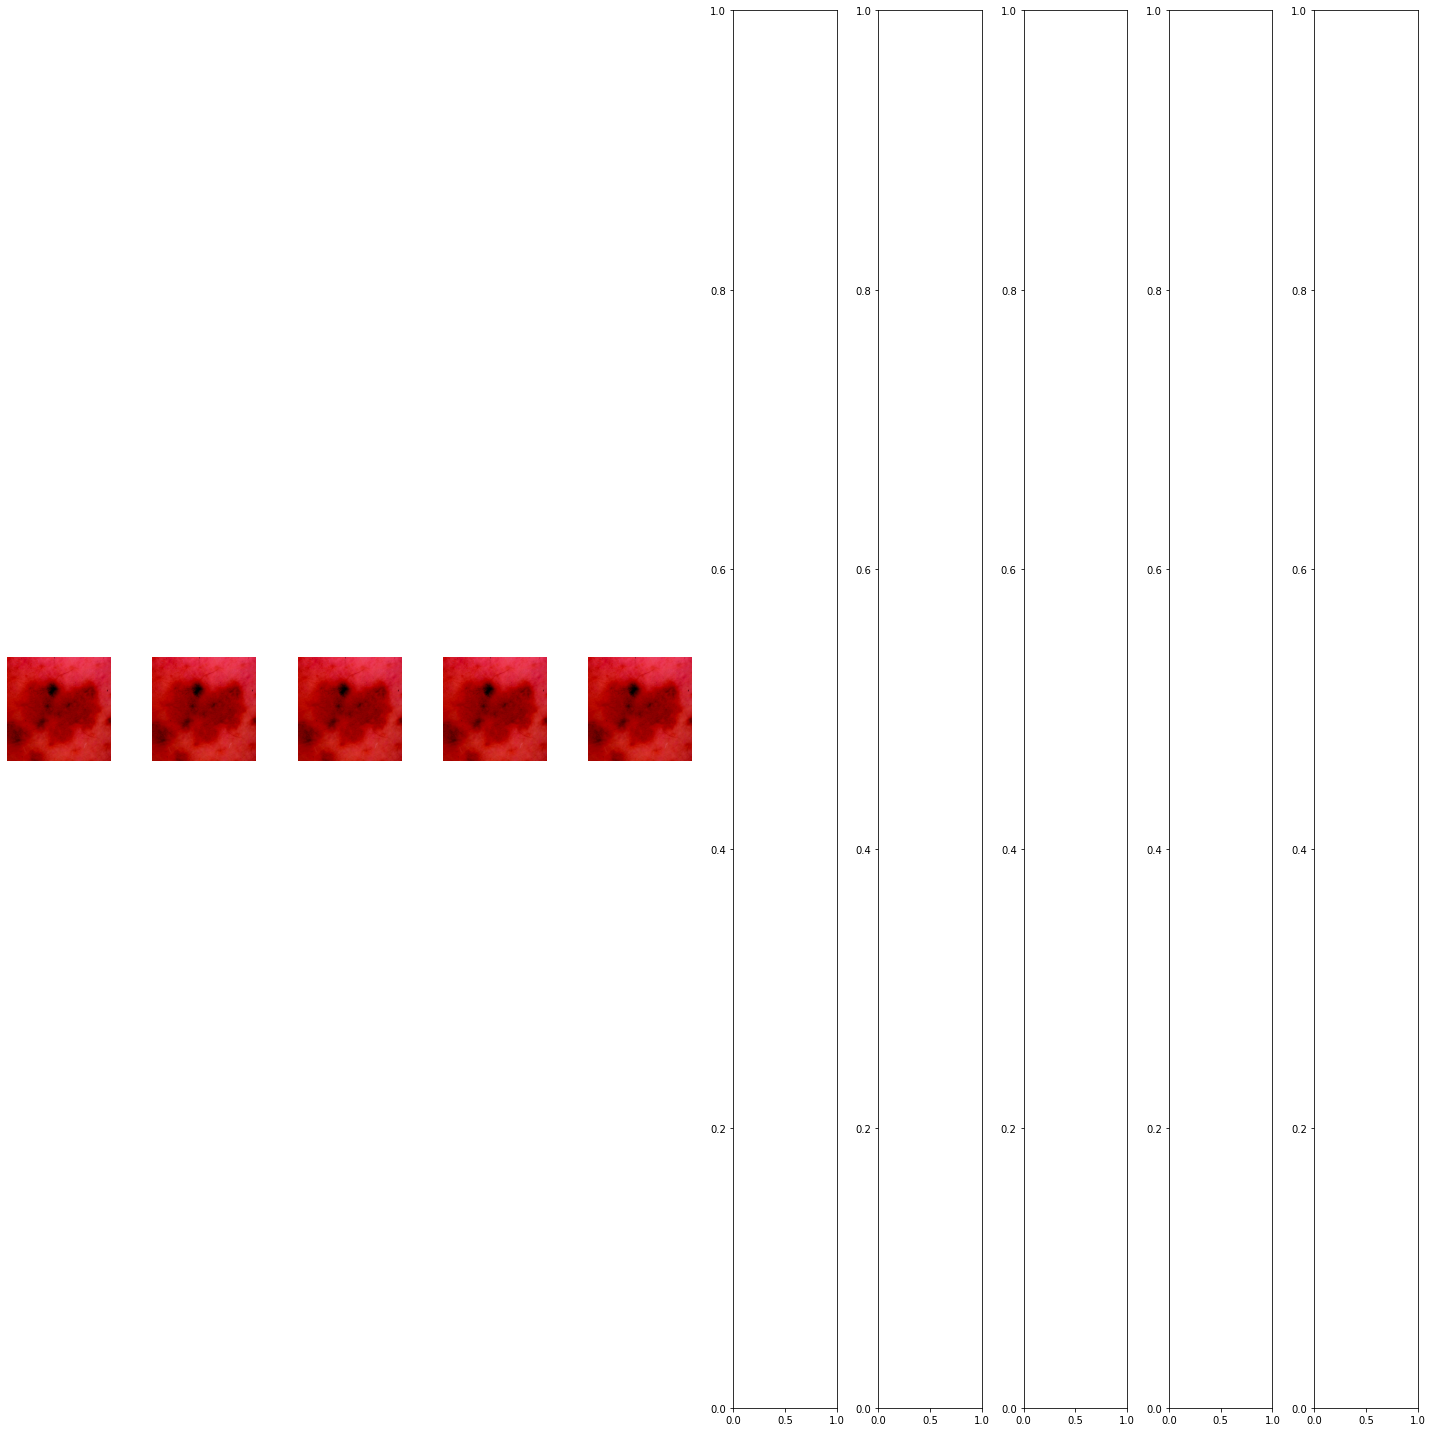

In [46]:
augmented_images = [resnet_v2_train_batches_v2[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [47]:
resnet_v2_model_v2 = Sequential([
        
        Conv2D(filters=16, kernel_size = (3,3), activation ='relu', padding='same', input_shape=(IMG_SHAPE,IMG_SHAPE, 3)),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        
        Conv2D(filters=32, kernel_size = (3,3), activation ='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        
        Conv2D(filters=64, kernel_size = (3,3), activation ='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        
        Conv2D(filters=128, kernel_size = (3,3), activation ='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        
        Flatten(),
        Dropout(0.5),
        
        Dense(units=512,kernel_regularizer = tf.keras.regularizers.l2(0.001), activation='relu'),
        Dense(units=2, activation='softmax')  
])

In [48]:
resnet_v2_model_v2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 28, 28, 64)      

In [49]:
resnet_v2_model_v2.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [50]:
history_resnet_v2_model_v2 = resnet_v2_model_v2.fit(x=resnet_v2_train_batches_v2,
    steps_per_epoch=len(resnet_v2_train_batches_v2),
    validation_data=resnet_v2_valid_batches_v2,
    validation_steps=len(resnet_v2_valid_batches_v2),
    epochs=50,
    batch_size = batch_size,
    verbose=1
)

Epoch 1/50
59/59 [==============================] - 91s 2s/step - loss: 1.3515 - accuracy: 0.7172 - val_loss: 1.0250 - val_accuracy: 0.8404
Epoch 2/50
59/59 [==============================] - 92s 2s/step - loss: 1.0303 - accuracy: 0.7753 - val_loss: 0.8351 - val_accuracy: 0.8558
Epoch 3/50
59/59 [==============================] - 90s 2s/step - loss: 0.8595 - accuracy: 0.8032 - val_loss: 0.7287 - val_accuracy: 0.8692
Epoch 4/50
59/59 [==============================] - 89s 1s/step - loss: 0.7750 - accuracy: 0.8210 - val_loss: 0.6904 - val_accuracy: 0.8750
Epoch 5/50
59/59 [==============================] - 90s 2s/step - loss: 0.7248 - accuracy: 0.8296 - val_loss: 0.6761 - val_accuracy: 0.8500
Epoch 6/50
59/59 [==============================] - 91s 2s/step - loss: 0.6552 - accuracy: 0.8403 - val_loss: 0.6261 - val_accuracy: 0.8635
Epoch 7/50
59/59 [==============================] - 89s 2s/step - loss: 0.6295 - accuracy: 0.8366 - val_loss: 0.6169 - val_accuracy: 0.8500
Epoch 8/50
59/59 [==

21/21 [==============================] - 11s 523ms/step
Confusion matrix, without normalization
[[280  80]
 [ 19 281]]


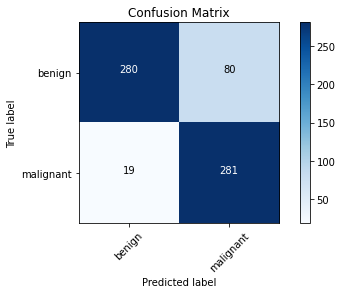

In [51]:
resnet_v2_predictions_v2 = resnet_v2_model_v2.predict(x=resnet_v2_test_batches_v2, steps=len(resnet_v2_test_batches_v2), verbose=1)
np.round(resnet_v2_predictions_v2)
resnet_v2_cm_v2 = confusion_matrix(y_true=resnet_v2_test_batches_v2.classes, y_pred=np.argmax(resnet_v2_predictions_v2, axis=-1))
cm_plot_labels = ['benign','malignant']
plot_confusion_matrix(cm=resnet_v2_cm_v2, classes=cm_plot_labels, title='Confusion Matrix')

In [52]:
resnet_v2_model_json = resnet_v2_model_v2.to_json()
with open("./SkinCancer_v3_Models/resnetV2_model_v2/resnet_v2_model_v2.json", "w") as json_file:
    json_file.write(resnet_v2_model_json)
resnet_v2_model_v2.save("./SkinCancer_v3_Models/resnetV2_model_v2/resnet_v2_model_v2.h5")
print("Saved model to disk")
resnet_v2_model_v2.save_weights("./SkinCancer_v3_Models/resnetV2_model_v2/resnet_v2_model_v2_Weights.h5")

Saved model to disk


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


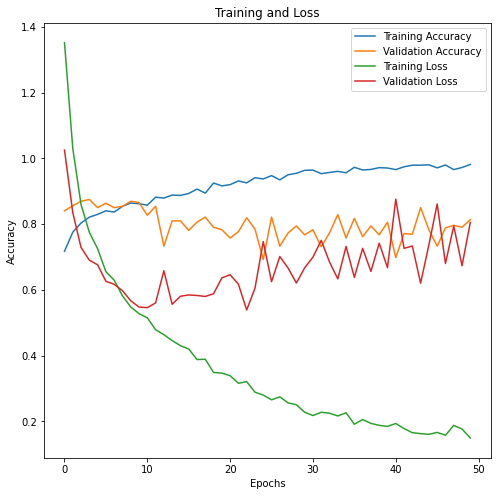

In [53]:
history_dict = history_resnet_v2_model_v2.history
print(history_dict.keys())

acc = history_resnet_v2_model_v2.history['accuracy']
val_acc = history_resnet_v2_model_v2.history['val_accuracy']

loss = history_resnet_v2_model_v2.history['loss']
val_loss = history_resnet_v2_model_v2.history['val_loss']

epochs_range = range(50)
plt.figure(figsize=(8, 8))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='best')
plt.title('Training and Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [54]:
resnet_v2_results_v2 = resnet_v2_model_v2.evaluate(x=resnet_v2_test_batches_v2, steps=len(resnet_v2_test_batches_v2), verbose=1)
print("test_loss, test accuracy",resnet_v2_results_v2)

21/21 [==============================] - 9s 442ms/step - loss: 0.6675 - accuracy: 0.8500
test_loss, test accuracy [0.6674522161483765, 0.8500000238418579]


In [55]:
pred_class = np.argmax(resnet_v2_predictions_v2, axis=1)

true_classes = resnet_v2_test_batches_v2.classes
class_labels = list(resnet_v2_test_batches_v2.class_indices.keys())  
report = metrics.classification_report(pred_class,true_classes,target_names=class_labels)
print(report)

              precision    recall  f1-score   support

      benign       0.78      0.94      0.85       299
   malignant       0.94      0.78      0.85       361

    accuracy                           0.85       660
   macro avg       0.86      0.86      0.85       660
weighted avg       0.86      0.85      0.85       660



21/21 [==============================] - 10s 483ms/step


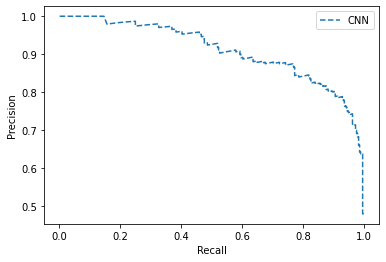

In [56]:
lr_probs = resnet_v2_model_v2.predict(x=resnet_v2_test_batches_v2, steps=len(resnet_v2_test_batches_v2), verbose=1)
lr_probs = lr_probs[:, 1]
lr_precision, lr_recall, _ = precision_recall_curve(true_classes, lr_probs)
no_skill = len(true_classes[true_classes==1]) / len(true_classes)
plt.plot(lr_recall, lr_precision, linestyle='--',label='CNN')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

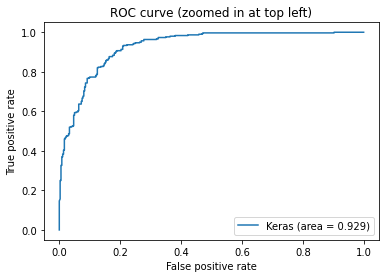

In [57]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(true_classes, lr_probs)
auc_keras = auc(fpr_keras, tpr_keras)
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [ ]:
# load json and create model

json_file = open('Skin_cancer_classification.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("SCC-Weights.h5")
loaded_model.compile(optimizer='adam', loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['acc'])
print("Loaded model from disk")